In [3]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from cloudvolume import CloudVolume, view
import napari
from sklearn.mixture import GaussianMixture
%gui qt

/Users/mattf/Applications/anaconda3/lib/python3.7/site-packages/napari/__init__.py:27: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.9.6. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


In [4]:
cv = CloudVolume(
        'https://d2zu5izn76slwn.cloudfront.net/precomputed_volumes/brain1',
        progress=True,
        mip = 0,
        cache=False,
        parallel=True,
    )

In [5]:
# Bijan's functions

def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()

    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]

        # the the number of components is 3 or 4 consider it an RGB image
        if c not in (3, 4):
            nda = nda[nda.shape[0] // 2, :, :]

    elif nda.ndim == 4:
        c = nda.shape[-1]

        if c not in (3, 4):
            raise RuntimeError("Unable to show 3D-vector Image")

        # take a z-slice
        nda = nda[nda.shape[0] // 2, :, :, :]

    xsize = nda.shape[1]*2
    ysize = nda.shape[0]*2

    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * xsize / dpi, (1 + margin) * ysize / dpi

    plt.figure(figsize=figsize, dpi=dpi, tight_layout=True)
    ax = plt.gca()

    extent = (0, xsize * spacing[0], ysize * spacing[1], 0)

    t = ax.imshow(nda, extent=extent, interpolation=None)

    if nda.ndim == 2:
        t.set_cmap("gray")

    if(title):
        plt.title(title)

    plt.show()


def myshow3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05,
             dpi=80):
    img_xslices = [img[s, :, :] for s in xslices]
    img_yslices = [img[:, s, :] for s in yslices]
    img_zslices = [img[:, :, s] for s in zslices]

    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))


    img_null = sitk.Image([0, 0], img.GetPixelID(),
                          img.GetNumberOfComponentsPerPixel())

    img_slices = []
    d = 0

    if len(img_xslices):
        img_slices += img_xslices + [img_null] * (maxlen - len(img_xslices))
        d += 1

    if len(img_yslices):
        img_slices += img_yslices + [img_null] * (maxlen - len(img_yslices))
        d += 1

    if len(img_zslices):
        img_slices += img_zslices + [img_null] * (maxlen - len(img_zslices))
        d += 1

    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen, d])
        # TO DO check in code to get Tile Filter working with vector images
        else:
            img_comps = []
            for i in range(0, img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i)
                                for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen, d]))
            img = sitk.Compose(img_comps)

    myshow(img, title, margin, dpi)
    
def scale(verts):
    scales = cv.scales[1]['resolution']
    scaled = verts/scales
    int_scaled = [int(i) for i in scaled]
    return np.array(int_scaled).reshape(-1,1)

def up_to_img(seg_id, v_id):
    SEGID=seg_id
    cv_skel = CloudVolume(
        'https://d2zu5izn76slwn.cloudfront.net/precomputed_volumes/brain1_segments',
        mip = 0,
        cache=False,
        parallel=False,
    )
    skel = cv_skel.skeleton.get(SEGID) 
    
    img = cv.download_point( scale(skel.vertices[v_id]), 
                        mip=1, size=(100,100,100),
                        coord_resolution=cv.scales[1]['resolution'])
    
    return img, cv

def img_to_labels(img, low=28, up=255, confidence_connected = False):
    img_T1 = sitk.GetImageFromArray(np.squeeze(img), isVector=False)
    img_T1_255 = sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8)
    seed = (50,50,50)
    seg = sitk.Image(img_T1.GetSize(), sitk.sitkUInt8)
    seg.CopyInformation(img_T1)
    seg[seed] = 1
    seg = sitk.BinaryDilate(seg, 1)
    
    if confidence_connected:
        seg_con = sitk.ConfidenceConnected(img_T1, seedList=[seed],
                                   numberOfIterations=1,
                                   multiplier=1,
                                   initialNeighborhoodRadius=1,
                                   replaceValue=1)
    else:
        seg_con = sitk.ConnectedThreshold(img_T1_255, seedList=[seed],
                                      lower=low, upper=up)

        #myshow(sitk.LabelOverlay(img_T1_255, seg), "ConfidenceConnected")
    
    vectorRadius = (1, 1, 1)
    kernel = sitk.sitkBall
    seg_clean = sitk.BinaryMorphologicalClosing(seg_con,
                                                vectorRadius,
                                                kernel)
    
    myshow3d(sitk.LabelOverlay(img_T1_255, seg_clean),
         zslices=range(48,53), title="Closed Connected Threshold")
    labels = sitk.GetArrayFromImage(seg_clean)
    return labels

In [6]:
#### Matt's functions

In [7]:
def fast_marching_seg(img_T1):
    seed = (50,50,50)
    feature_img = sitk.GradientMagnitudeRecursiveGaussian(img_T1, sigma=.5)
    speed_img = sitk.BoundedReciprocal(feature_img) # This is parameter free unlike the Sigmoid
    myshow(speed_img)
    
    fm_filter = sitk.FastMarchingBaseImageFilter()
    fm_filter.SetTrialPoints([seed])
    fm_filter.SetStoppingValue(1000)
    fm_img = fm_filter.Execute(speed_img)
    myshow3d(fm_img,
         zslices=range(48,53), title="Fast marching")
    labels = sitk.GetArrayFromImage(fm_img)
    return labels
    #myshow(sitk.Threshold(fm_img,
     #                   lower=0.0,
      #                  upper=fm_filter.GetStoppingValue(),
       #                 outsideValue=fm_filter.GetStoppingValue()+1))

In [8]:
def level_set_seg(img_T1, factor = 2):
    seed = (50,50,50)
    seg = sitk.Image(img_T1.GetSize(), sitk.sitkUInt8)
    seg.CopyInformation(img_T1)
    seg[seed] = 1
    seg = sitk.BinaryDilate(seg, 1)
    stats = sitk.LabelStatisticsImageFilter()
    stats.Execute(img_T1, seg)
    #factor = factor
    lower_threshold = stats.GetMean(1)-factor*stats.GetSigma(1)
    upper_threshold = stats.GetMean(1)+factor*stats.GetSigma(1)
    print(lower_threshold,upper_threshold)
    init_ls = sitk.SignedMaurerDistanceMap(seg, insideIsPositive=True, useImageSpacing=True)
    lsFilter = sitk.ThresholdSegmentationLevelSetImageFilter()
    lsFilter.SetLowerThreshold(lower_threshold)
    lsFilter.SetUpperThreshold(upper_threshold)
    lsFilter.SetMaximumRMSError(0.02)
    lsFilter.SetNumberOfIterations(1000)
    lsFilter.SetCurvatureScaling(.5)
    lsFilter.SetPropagationScaling(1)
    lsFilter.ReverseExpansionDirectionOn()
    ls = lsFilter.Execute(init_ls, sitk.Cast(img_T1, sitk.sitkFloat32))
    print(lsFilter)
    myshow(sitk.LabelOverlay(img_T1_255, ls>0))
    myshow3d(sitk.LabelOverlay(img_T1_255, ls>0),
         zslices=range(48,53), title="LS Seg")
    labels = sitk.GetArrayFromImage(ls>0)
    return labels

In [9]:
def gmm_output(img, seed=2):
    img_T1 = sitk.GetImageFromArray(np.squeeze(img), isVector=False)
    img_T1_255 = sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8)
    v = sitk.GetArrayFromImage(img_T1_255)
    flat = v.flatten().reshape(-1,1) #img
    gmm = GaussianMixture(n_components=2, random_state=seed)
    y = gmm.fit_predict(flat)
    
    return y.reshape(img.shape).squeeze()

In [10]:
def thres_from_gmm(img, seed=2):
    img_T1 = sitk.GetImageFromArray(np.squeeze(img), isVector=False)
    img_T1_255 = sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8)
    v = sitk.GetArrayFromImage(img_T1_255)
    flat = v.flatten().reshape(-1,1) #img
    gmm = GaussianMixture(n_components=2, random_state=seed)
    y = gmm.fit_predict(flat)
    mask = y.astype(bool)
    a = flat[mask]
    b = flat[~mask]
    #print(a.max(), b.max(), a.min(), b.min())
    if a.max() > b.max():
        thres = a.min()
        #print("A")
    else:
        thres = b.min()
        #print("B")  
    #print(mask.shape, a.shape, b.shape)
    
    return int(thres)

In [11]:
def img_to_gmm_labels(img):
    img_T1 = sitk.GetImageFromArray(np.squeeze(img), isVector=False)
    img_T1_255 = sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8)    
    seg_clean = sitk.GetImageFromArray(gmm_output(img),isVector=False)
    
    myshow3d(sitk.LabelOverlay(img_T1_255, seg_clean),
         zslices=range(48,53), title="GMM - 2 Components")
    labels = sitk.GetArrayFromImage(seg_clean)
    return labels

In [12]:
img, cv = up_to_img(2, 400)

Downloading:   0%|          | 0/4 [00:00<?, ?it/s]








In [13]:
thres_from_gmm(img)

11

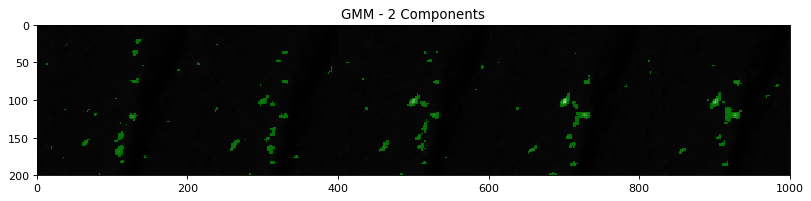

<Labels layer 'GMM Output' at 0x13dd7e550>

In [14]:
labels = img_to_gmm_labels(img)
viewer = napari.view_image(np.squeeze(np.array(img)))
viewer.add_labels(labels, name='GMM Output')
# NOTE: This opens Napari in a new window for 3D visualization

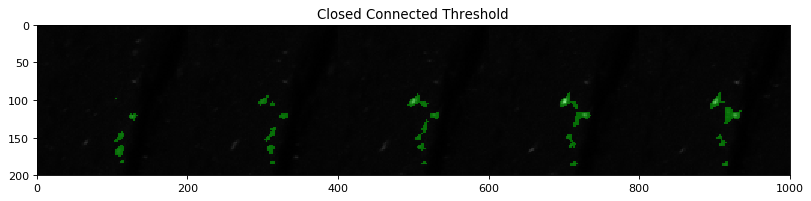

<Labels layer 'Segmentation' at 0x19c9e7278>

In [49]:
labels = img_to_labels(img, low=thres_from_gmm(img))
viewer = napari.view_image(np.squeeze(np.array(img)))
viewer.add_labels(labels, name='Segmentation')
# NOTE: This opens Napari in a new window for 3D visualization

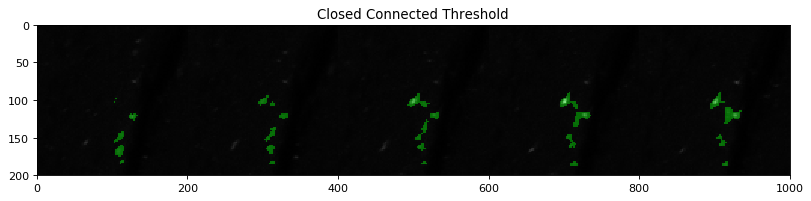

<Labels layer 'Confidence Connected Segmentation' at 0x1984cbb70>

In [50]:
labels = img_to_labels(img, low=thres_from_gmm(img), confidence_connected = True)
viewer = napari.view_image(np.squeeze(np.array(img)))
viewer.add_labels(labels, name='Confidence Connected Segmentation')
# NOTE: This opens Napari in a new window for 3D visualization

In [38]:
def run_otsu(img):
    img_T1 = sitk.GetImageFromArray(np.squeeze(img), isVector=False)
    img_T1_255 = sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8)

    otsu_filter = sitk.OtsuThresholdImageFilter()
    otsu_filter.SetInsideValue(0)
    otsu_filter.SetOutsideValue(1)
    seg = otsu_filter.Execute(img_T1)
    myshow(sitk.LabelOverlay(img_T1_255, seg), "Otsu Thresholding")
    myshow3d(sitk.LabelOverlay(img_T1_255, seg),
             zslices=range(48,53), title="Otsu")
    labels = sitk.GetArrayFromImage(seg)
    return labels

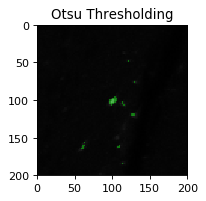

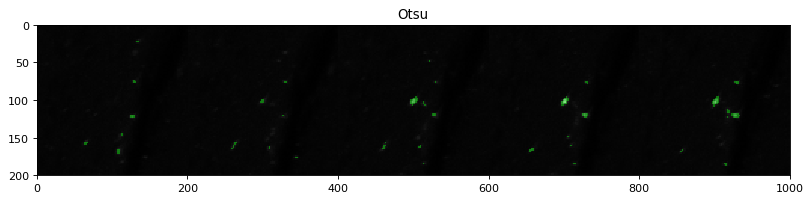

<Labels layer 'Segmentation' at 0x1704f4828>

In [39]:
labels = run_otsu(img)
viewer = napari.view_image(np.squeeze(np.array(img)))
viewer.add_labels(labels, name='Segmentation')

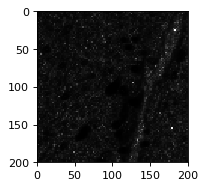

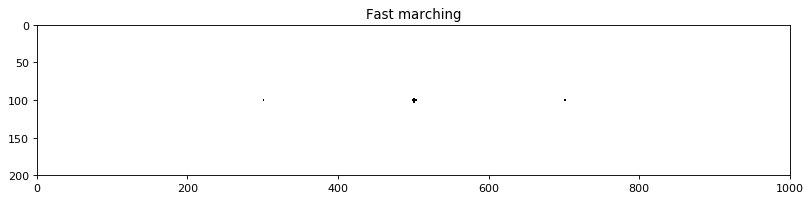

<Labels layer 'Segmentation' at 0x146a26f98>

In [21]:
labels = fast_marching_seg(img_T1)
viewer = napari.view_image(np.squeeze(np.array(img)))
viewer.add_labels(labels, name='FM Segmentation')

11581.140117642928 35058.75461919918
itk::simple::ThresholdSegmentationLevelSetImageFilter
  LowerThreshold: 11581.1
  UpperThreshold: 35058.8
  MaximumRMSError: 0.02
  PropagationScaling: 1
  CurvatureScaling: 0.5
  NumberOfIterations: 1000
  ReverseExpansionDirection: 1
  ElapsedIterations: 214
  RMSChange: 0.0197264
  Debug: 0
  NumberOfThreads: 8
  Commands: (none)
  ProgressMeasurement: 0.214
  ActiveProcess: (none)



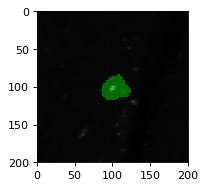

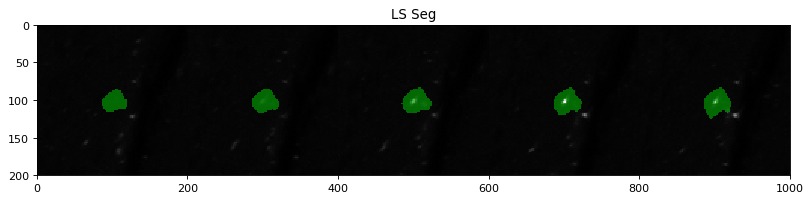

<Labels layer 'Segmentation' at 0x162eb7b38>

In [35]:
labels = level_set_seg(img_T1, factor = 1.35)
viewer = napari.view_image(np.squeeze(np.array(img)))
viewer.add_labels(labels, name='Segmentation')
# NOTE: This opens Napari in a new window for 3D visualization

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from cloudvolume import CloudVolume, view
from sklearn.mixture import GaussianMixture
import napari

class NeuroglancerSession():
    def __init__(self, url='https://d2zu5izn76slwn.cloudfront.net/precomputed_volumes/brain1', mip=1):
        self.seed = 1111
        self.url = url
        self.mip = mip
        cv = CloudVolume(
                self.url,
                progress=True,
                mip = 0,
                cache=False,
                parallel=True,
            )
        self.cv = cv
        cv_skel = CloudVolume(
            self.url+'_segments',
            mip = 0,
            cache=False,
            parallel=False,
        )
        self.cv_skel = cv_skel
        self.img = None
        self.labels = None
        self.chunk_size = (66, 50, 52)
        self.sx = None
        self.sy = None
        self.sz = None


    def _scale(self, verts):
        scales = self.cv.scales[self.mip]['resolution']
        scaled = verts/scales
        int_scaled = [int(i) for i in scaled]
        return np.array(int_scaled).reshape(-1,1)

    def get_img(self, seg_id, v_id, sx=5, sy=5, sz=5):
        """Gets image around a the (v_id)-th vertex in the neuron skeleton.
        Returns the image and skeleton
        """
        SEGID=seg_id
        skel = self.cv_skel.skeleton.get(SEGID)
        img = self.cv.download_point(self._scale(skel.vertices[v_id]),
                            mip=self.mip, size=(self.chunk_size[0]*sx,
                                           self.chunk_size[1]*sy,
                                           self.chunk_size[2]*sz),
                            coord_resolution=self.cv.scales[self.mip]['resolution'])
        self.img = img
        self.sx = sx
        self.sy = sy
        self.sz = sz

        ## TODO: convert skel.vertices into voxel coordinates relative to img
        return img, skel

    def view_img(self, img=None, title='View'):
        if img is None:
            img = self.img
        if img is None:
            raise ValueError(f'Need an image to view it, not {type(img)}')
        else:
            with napari.gui_qt():
                viewer = napari.view_image(np.squeeze(np.array(self.img)))
                if self.labels is not None:
                    viewer.add_labels(self.labels, name='segmentation')
        return

    def _img_to_labels(self, img=None, low=None, up=255):
        if img is None:
            img = self.img
        img_T1 = sitk.GetImageFromArray(np.squeeze(img), isVector=False)
        img_T1_255 = sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8)
        seed = (int(self.chunk_size[2]*self.sz/2),
                int(self.chunk_size[1]*self.sy/2),
                int(self.chunk_size[0]*self.sx/2))
        seg = sitk.Image(img_T1.GetSize(), sitk.sitkUInt8)
        seg.CopyInformation(img_T1)
        seg[seed] = 1
        seg = sitk.BinaryDilate(seg, 1)
        if low is None:
            v = sitk.GetArrayFromImage(img_T1_255)
            flat = v.flatten().reshape(-1,1) #img
            gmm = GaussianMixture(n_components=2, random_state=self.seed)
            gmm.fit(flat)
            low = np.divide(gmm.means_[0][0]*gmm.covariances_[0][0]+
                    gmm.means_[1][0]*gmm.covariances_[1][0],
                    gmm.covariances_[0][0]+gmm.covariances_[1][0])
            print("result:", low)
        seg_con = sitk.ConnectedThreshold(img_T1_255, seedList=[seed],
                                          lower=int(np.round(low)), upper=up)
        vectorRadius = (1, 1, 1)
        kernel = sitk.sitkBall
        seg_clean = sitk.BinaryMorphologicalClosing(seg_con,
                                                    vectorRadius,
                                                    kernel)
        labels = sitk.GetArrayFromImage(seg_clean)
        return labels
    
    def matt_img_to_labels(img, low=28, up=255, confidence_connected = False):
        img_T1 = sitk.GetImageFromArray(np.squeeze(img), isVector=False)
        img_T1_255 = sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8)
        seed = (int(self.chunk_size[2]*self.sz/2),
                int(self.chunk_size[1]*self.sy/2),
                int(self.chunk_size[0]*self.sx/2))
        seg = sitk.Image(img_T1.GetSize(), sitk.sitkUInt8)
        seg.CopyInformation(img_T1)
        seg[seed] = 1
        seg = sitk.BinaryDilate(seg, 1)

        if confidence_connected:
            seg_con = sitk.ConfidenceConnected(img_T1, seedList=[seed],
                                       numberOfIterations=1,
                                       multiplier=1,
                                       initialNeighborhoodRadius=1,
                                       replaceValue=1)
        else:
            seg_con = sitk.ConnectedThreshold(img_T1_255, seedList=[seed],
                                          lower=low, upper=up)

            #myshow(sitk.LabelOverlay(img_T1_255, seg), "ConfidenceConnected")

        vectorRadius = (1, 1, 1)
        kernel = sitk.sitkBall
        seg_clean = sitk.BinaryMorphologicalClosing(seg_con,
                                                    vectorRadius,
                                                    kernel)

        myshow3d(sitk.LabelOverlay(img_T1_255, seg_clean),
             zslices=range(48,53), title="Closed Connected Threshold")
        labels = sitk.GetArrayFromImage(seg_clean)
        return labels

    def add_labels(self, labels=None, low=None):
        if labels is None:
            labels = matt_img_to_labels(img, low=thres_from_gmm(img), confidence_connected = True)
        print('ok')
        if not np.any(labels):
            print("Matrix is all 0!")
        self.labels = labels
        return self.labels

    def push_img(self, img=None, url='s3://mouse-light-viz/precomputed_volumes/brain1_seg'):
        vol = CloudVolume(url,
                  mip=self.mip,
                  non_aligned_writes=True,
                  fill_missing=True,
                  delete_black_uploads=False)
        if img is None:
            img = self.labels
        if img is None:
            raise Exception("you are pushing None")
        bounds = self.img.bounds.to_list()
        vol[bounds[0]:bounds[3], bounds[1]:bounds[4], bounds[2]:bounds[5]] = img.astype('uint64')
        return

In [1]:
# Best results

In [18]:
ngl_sesh = NeuroglancerSession()

vol = ngl_sesh.get_img(2, 799, sx=5, sy=5, sz=5)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
Downloading: 52it [00:16,  3.06it/s]                        
Downloading: 50it [00:16,  1.92it/s]                        
Downloading: 52it [00:16,  2.09it/s]                        
Downloading: 52it [00:16,  2.26it/s]                        
Downloading: 52it [00:17,  2.33it/s]                        
Downloading: 52it [00:17,  2.70it/s]                        
Downloading: 50it [00:17,  3.13it/s]                        
Downloading: 52it [00:17,  2.06it/s]                        


In [21]:
labels = ngl_sesh.add_labels(low=8)

ok


In [22]:

ngl_sesh.img.bounds.to_list()

[7389, 2485, 3080, 7719, 2735, 3340]

In [23]:
ngl_sesh._scale(ngl_sesh.cv_skel.skeleton.get(2).vertices[799])*2

Downloading: 100%|██████████| 1/1 [00:00<00:00,  6.65it/s]


array([[15110],
       [ 5220],
       [ 6420]])

In [24]:
ngl_sesh.push_img()

KeyError: 'AWS_ACCESS_KEY_ID'